In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

In [7]:
import sys 
sys.path.append("/home/jh27kim/code/current_projects/MNISTDiffusion")

from conditional_mnist.model.instance_model import InstanceDDPM
from conditional_mnist.model.instance_model import InstanceContextUnet


In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

def pil_to_torch(pil_img):
    _np_img = np.array(pil_img).astype(np.float32) / 255.0
    _torch_img = torch.from_numpy(_np_img).permute(2, 0, 1).unsqueeze(0)
    return _torch_img

def torch_to_pil(tensor):
    if tensor.dim() == 4:
        _b, *_ = tensor.shape
        if _b == 1:
            tensor = tensor.squeeze(0)
        else:
            tensor = tensor[0, ...]
    
    tensor = tensor.permute(1, 2, 0)
    
    np_tensor = tensor.detach().cpu().numpy()
    np_tensor = (np_tensor * 255.0).astype(np.uint8)
    pil_tensor = Image.fromarray(np_tensor)
    return pil_tensor

In [9]:
n_T = 400 # 500
device = "cuda:0"
n_classes = 10
n_feat = 128 # 128 ok, 256 better (but slower)
guide_w = 2.0
instance_size = 16 # 14
img_per_side = 2 # 3
n_regions = img_per_side**2

ddpm = InstanceDDPM(
    nn_model=InstanceContextUnet(
            in_channels=1, 
            instance_size=instance_size,
            n_feat=n_feat, 
            n_classes=n_classes, 
            n_regions=n_regions,
        ), 
    betas=(1e-4, 0.02), 
    n_T=n_T, 
    device=device, 
    drop_prob=0.1
)

ckpt_path = "/home/jh27kim/code/current_projects/MNISTDiffusion/conditional_mnist/ckpt/instance_concatmodel_19.pth"
ddpm.load_state_dict(torch.load(ckpt_path))
print("Loaded checkpoint")

ddpm.to(device)
ddpm.eval()
print("Loaded model")

alphas_cumprod individual assigned
Loaded checkpoint
Loaded model


/tmp/ipykernel_1369335/1280180488.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm.load_state_dict(torch.load(ckpt_path))


In [12]:
MNIST_IMG_SIZE = 28
stride = instance_size - (instance_size * img_per_side - MNIST_IMG_SIZE) // (img_per_side-1)
region_list = []
for i in range(0, 28, stride):
    for j in range(0, 28, stride):
        if i + instance_size <= MNIST_IMG_SIZE and j + instance_size <= MNIST_IMG_SIZE:
            region_list.append(
                torch.tensor(
                    [i, j, i+instance_size, j+instance_size]
                ).unsqueeze(0)
            )
        else:
            break
region_list = torch.cat(region_list, dim=0).to(device)

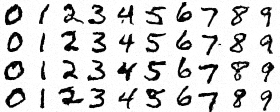

In [20]:
eff_n_sample = 4*n_classes
inst_n_sample = 4*n_classes * n_regions

box_cls = torch.arange(0, n_regions).repeat(eff_n_sample).to(device)
box = region_list[box_cls].to(device)

with torch.no_grad():
    x_gen, x_gen_store = ddpm.inst_sample(
        eff_n_sample,  inst_n_sample, 
        (1, instance_size, instance_size), 
        device, guide_w=2.0, 
        box_cls=box_cls, box=box,
        eff_size=(1, MNIST_IMG_SIZE, MNIST_IMG_SIZE),
    )
    
    x_gen = (x_gen *-1 + 1).clamp(0, 1)
    x_gen = torch.cat([x_gen] * 3, dim=1)
    image_grid_list = [torch_to_pil(x) for x in x_gen] 
    
    res = image_grid(
        image_grid_list, 
        rows=4,
        cols=n_classes,
    )
    
res

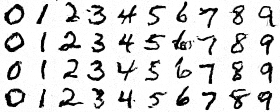

In [19]:
with torch.no_grad():
    x_gen, x_gen_store = ddpm.ddim_sample(
        eff_n_sample,  inst_n_sample, 
        (1, instance_size, instance_size), 
        device, guide_w=2.0, 
        box_cls=box_cls, box=box,
        eff_size=(1, MNIST_IMG_SIZE, MNIST_IMG_SIZE),
    )
    
    x_gen = (x_gen *-1 + 1).clamp(0, 1)
    x_gen = torch.cat([x_gen] * 3, dim=1)
    image_grid_list = [torch_to_pil(x) for x in x_gen] 
    
    res = image_grid(
        image_grid_list, 
        rows=4,
        cols=n_classes,
    )
    
res